# Image DownSampler Pipeline Interface
#### v_0.3
#### Created by: Chris Stewart - 2021/03/31
#### Updated: 2021/05/27

#### __Overview:__ The purpose of this notebook is to serve as the interface for the downSampler pipeline. It exposes the pipeline's parameters to the user to modify as needed, as well as displays feedback about the pipeline run state, and handles some basic wrapper and drive mounting functions. 
#### - Please take a moment to enjoy the following inspirational image of a pipeline:

![title](img/pipeline-1200x790.jpg)

image source: https://celdf.org/wp-content/uploads/2015/08/pipeline-1200x790.jpg

## Instructions for Usage:

The downSampler pipeline allows images from the aerial NEON image platform to be processed into a closer representation of simulated hyperspectral satellite imagery.
It specifically uses NEON's "Spectrometer orthorectified surface directional reflectance - mosaic" dataset which can be found and downloaded from here: https://data.neonscience.org/data-products/DP3.30006.001

There are many sites and other filters that allow to selecting certain areas, dates, etc. One limitation however is that there may be no/limited coverage for some areas.

Once you have downloaded the data sets you want, unzip the data folder and copy it into the "pipeline_input" folder located in: code_working_dir > hyperspectral-project > data > pipeline_input. The downsampled and rebanded processed hdf5 and preview image files will be saved in the "pipeline_output" folder (next to the input one).

Important Note: Once you have processed the input data files, move them out of the pipeline_input folder or the next time the pipeline is run they will be processed again (likely undesired).

Citation for Rocky Mountain Site Data: National Ecological Observatory Network. 2021. Data Product DP3.30006.001, Spectrometer orthorectified surface directional reflectance - mosaic. Provisional data downloaded from http://data.neonscience.org on April 1, 2021. Battelle, Boulder, CO, USA NEON. 2021.

### Setup Code:
Always run this after restarting notebook to load the pipeline package

In [2]:
import os
import sys
from pathlib import Path
import logging
root_logger = logging.getLogger()
root_logger.setLevel(level=logging.INFO)
logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p', 
                    level=logging.INFO,
                    filename="debugging_nb.log")

logging.info('Pipeline workbook started')



# special code cell to mount google drive and change to the correct directory
# import os
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True) # mount google drive

# os.chdir('/content/gdrive/MyDrive/code_working_dir/hyperspectral-project/notebooks')

module_path = os.path.abspath(os.path.join('..')) # add the projects src code directory to the sys path to allow finding our module
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\data")
    #sys.path.insert(0, module_path+"\\src\\data")
    
import downSampler # load pipeline module

### Parameters:

The pipeline parameters include:
- data_dir_path : this is the input data directory where the pipeline will search for .h5 files to downsample
- output_data_path : this is where the pipeline will output the downsampled .h5 files and corresponding preview images (in their own respective sub-folders)
- desired_GSD : this is the desired Ground Sample Distance (GSD) to downsample to in m. Note: should be an integer >= 1 m
- desired_band_centres : this is the input band centres for the spectral re-banding portion in um. Default: [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804]

These are all fairly standard so likely will not need to be changed.

In [3]:
# parameter setup:
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' # path to input data files

desired_GSD = 5 # GSD in m
desired_band_centres = [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.73, 0.745, 0.762, 0.779, 0.787, 0.804]
# Our bands: [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.73, 0.745, 0.762, 0.779, 0.787, 0.804]

nodata_thres = 0.5 # fraction of allowable missing data
output_mode = 'geotiff' # sets the file type output

print("Parameters set!")

Parameters set!


### Find Input Files:

In [5]:
print("These are the input files found in the pipeline_input folder, ready to be processed:")
files_to_process = downSampler.find_files(data_dir_path)
for k in files_to_process.keys():
    print(k)

These are the input files found in the pipeline_input folder, ready to be processed:
Finding data files...
NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5
NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5
NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5
NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5
NEON_D10_RMNP_DP3_459000_4448000_2017_reflectance.h5
NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5


### Process Images:
Running the next code cell starts processing the image data. NOTE: depending on how many images are in the pipeline_input folder this might take a while - sit back and relax!

Parameters set...
Finding data files...
Input files found...
Processing file:  NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5
File loaded...
Downsampling Complete...
Generating STAC metadata file...


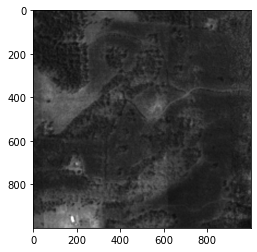

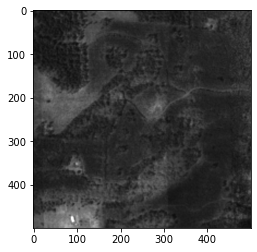

STAC metadata file generated!
Generating geotiff image files...
Geotiff image files generated!
Processing file:  NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5
File loaded...
Downsampling Complete...
Generating STAC metadata file...


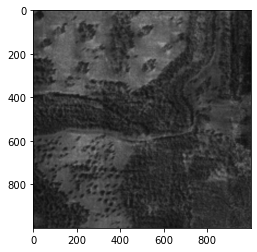

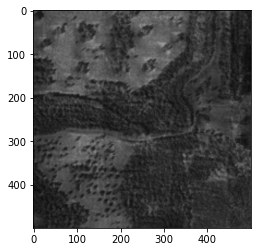

STAC metadata file generated!
Generating geotiff image files...
Geotiff image files generated!
Processing file:  NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5
% No Data:  5.7
File loaded...


In [ ]:
downSampler.pipeline(data_dir_path, output_data_path, desired_band_centres, nodata_thres, desired_GSD, output_mode)